<a href="https://colab.research.google.com/github/HinaRaja65/google-colab-codes/blob/main/Claasification_VGG_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Segmentation/Data/Train'

/content/drive/MyDrive/Segmentation/Data/Train


In [4]:
!pwd

/content/drive/MyDrive/Segmentation/Data/Train


In [5]:
os.listdir()

['.DS_Store',
 'License-GOALS-0606.pdf',
 'Train_GC_GT.xlsx',
 'Image',
 'Layer_Masks',
 'Layer_show']

In [6]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.7 MB/s 


In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten,Dropout, Conv2D, MaxPooling2D

from keras.layers import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [7]:
!pip install -q xlrd

In [10]:
# Reading the excel file in which we are going to write the labels of images
data_labels=pd.read_excel(r"Train_GC_GT.xlsx")
data_labels.head()

,ImgName,GC_Label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [11]:
labels=data_labels.iloc[:,1]
labels.head()

0    1
1    1
2    1
3    1
4    1
Name: GC_Label, dtype: int64

In [12]:
print('shape',labels.shape)
print('Type',labels.dtype)

shape (100,)
Type int64


In [13]:
SIZE = 256  #Resize images

In [14]:
train_images=[]

for img_path in glob.glob("Image/*"):
          print(img_path)
          img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
          img = cv2.resize(img, (SIZE, SIZE))
          img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
          train_images.append(img)
       

Image/0061.png
Image/0067.png
Image/0074.png
Image/0075.png
Image/0060.png
Image/0012.png
Image/0089.png
Image/0073.png
Image/0062.png
Image/0099.png
Image/0049.png
Image/0048.png
Image/0071.png
Image/0088.png
Image/0077.png
Image/0076.png
Image/0065.png
Image/0006.png
Image/0058.png
Image/0063.png
Image/0064.png
Image/0072.png
Image/0066.png
Image/0070.png
Image/0098.png
Image/0100.png
Image/0059.png
Image/0015.png
Image/0038.png
Image/0029.png
Image/0016.png
Image/0010.png
Image/0033.png
Image/0025.png
Image/0019.png
Image/0027.png
Image/0031.png
Image/0002.png
Image/0028.png
Image/0003.png
Image/0017.png
Image/0039.png
Image/0004.png
Image/0013.png
Image/0032.png
Image/0014.png
Image/0007.png
Image/0024.png
Image/0001.png
Image/0030.png
Image/0005.png
Image/0011.png
Image/0026.png
Image/0009.png
Image/0018.png
Image/0021.png
Image/0046.png
Image/0085.png
Image/0035.png
Image/0084.png
Image/0079.png
Image/0034.png
Image/0008.png
Image/0020.png
Image/0045.png
Image/0053.png
Image/0022

In [15]:
len(train_images)

100

In [27]:
#Convert lists to arrays        
train_images = np.array(train_images)
print("shape of images array", train_images.shape )
train_labels = np.array(labels)
print("shape of label array", train_labels.shape )

shape of images array (100, 256, 256, 3)
shape of label array (100,)


In [28]:
#Encode labels from text to integers.

le = preprocessing.LabelEncoder()
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [29]:
#Spliting the the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels_encoded, random_state=20, test_size=0.3)
print("training data:",X_train.shape)
print("training label:",y_train.shape)
print("test data:",X_test.shape)
print("test label:",y_test.shape)

training data: (70, 256, 256, 3)
training label: (70,)
test data: (30, 256, 256, 3)
test label: (30,)


In [30]:

# Normalize pixel values to between 0 and 1
x_train, x_test = X_train / 255.0, X_test / 255.0
'''
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
'''

'\n#One hot encode y values for neural network. \nfrom tensorflow.keras.utils import to_categorical\ny_train_one_hot = to_categorical(y_train)\ny_test_one_hot = to_categorical(y_test)\n'

In [20]:
#Load model without classifier(fully connected layers), only feature extractor
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))


VGG_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [21]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False

VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [22]:
#feature extraction 
feature_extractor=VGG_model.predict(x_train)

In [23]:
feature_extractor.shape

(70, 8, 8, 512)

In [26]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
print(features.shape)

(70, 32768)


In [31]:
X_for_RF = features #This is our X input to RF

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding


RandomForestClassifier(n_estimators=50, random_state=42)

In [32]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

In [34]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))

Accuracy =  0.43333333333333335


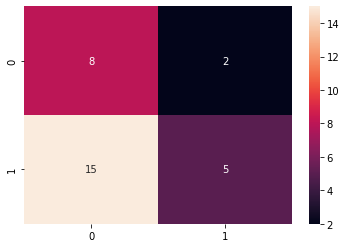

In [35]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

In [38]:
x_test.shape

(30, 256, 256, 3)

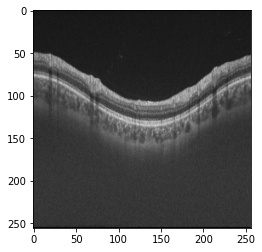

In [36]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)

In [37]:
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)

In [44]:
input_img_features.shape

(1, 32768)

In [46]:
prediction_RF = RF_model.predict(input_img_features)[0]
print(prediction_RF)


0


In [47]:
probability_RF = RF_model.predict_proba(input_img_features)
print("probality:",probability_RF)

probality: [[0.52 0.48]]


In [48]:
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", y_test[n])

The prediction for this image is:  [0]
The actual label for this image is:  1
